In [1]:
from kan.hypothesis import *
from torchvision import transforms
import torch
import torch.nn.functional as F
from kan import *
import h5py
import copy
import sympy as sp
dtype = torch.get_default_dtype()

In [2]:
data_dir = "./"
filename = "sg2-data.h5"
checkpoint_dir = "./saved_models/"
log_dir = './logs/'
band_idx = 0
gidxs = [1, 2, 3, 4]
only_obstructed = False
only_topological = False
binary_classification = False#True
no_penalize_last = True
bias = False
numrs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
file = h5py.File(data_dir + filename, 'r')
print("file keys: ", file['sg2/1/'].keys())

file keys:  <KeysViewHDF5 ['epsilon_Gs-gidx=1', 'epsilon_Gs-gidx=2', 'epsilon_Gs-gidx=3', 'epsilon_Gs-gidx=4', 'frequencies-gidx=1-mode=tm', 'frequencies-gidx=2-mode=tm', 'frequencies-gidx=3-mode=tm', 'frequencies-gidx=4-mode=tm', 'symmetry-gidx=1-mode=tm', 'symmetry-gidx=2-mode=tm', 'symmetry-gidx=3-mode=tm', 'symmetry-gidx=4-mode=tm']>


In [4]:
nGs = 10
gidxs = [1, 2, 3, 4]
wps = ['1a', '1b', '1c', '1d']
wps2 = ['1a', '1c', '1b', '1d'] # switch 1b and 1c due to convention of how Gvectors are stored

symmetry_data = torch.zeros(10000 * len(gidxs) * len(wps))
input_data = torch.zeros(10000 * len(gidxs) * len(wps), nGs)

In [5]:
for (widx, (wp1, wp2)) in enumerate(zip(wps, wps2)):
    print(f"Wyckoff index: {widx}")
    sym_vec_phases = file[f'sg2/symmetry_vector_phases/{wp1}'][()]
    epsilon_G_phases = file[f'sg2/epsilon_G_phases/{wp2}'][()].real
    for gidx in gidxs:
        print(f"gidx: {gidx}")
        for id in range(1, 10001):
            real_id = (id-1) + (gidx-1)*10000 + len(gidxs)*10000*widx
            if (id % 1000 == 0): 
                print(id)
            symmetry_before_aug = file[f'sg2/{id}/symmetry-gidx={gidx}-mode=tm'][()][0]
            symmetry_data[real_id] =  sym_vec_phases[symmetry_before_aug] - 8
            fourier_data_before_aug = file[f'sg2/{id}/epsilon_Gs-gidx={gidx}'][()][0:nGs].real
            fourier_data = fourier_data_before_aug * epsilon_G_phases
            input_data[real_id, :] = torch.tensor([*fourier_data])


Wyckoff index: 0
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wyckoff index: 1
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wyckoff index: 2
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Wyckoff index: 3
gidx: 1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 2
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 3
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
gidx: 4
1000
2000
3000
4000
5000
6000
7000
8000

In [6]:
shuffled_indices = torch.randperm(10000 * len(gidxs) * len(wps))
input_data_shuffled = input_data[shuffled_indices, :]
symmetry_data_shuffled = symmetry_data[shuffled_indices]

In [7]:
dataset_kan = {}
n_train = 80000#int(input_data_shuffled.shape[0]*2/3)
nGs = 5
nGstart = 0
dataset_kan['train_input'] = input_data_shuffled[0:n_train, [*range(nGstart, nGs)]].to(device)
dataset_kan['test_input'] = input_data_shuffled[n_train:, [*range(nGstart, nGs)]].to(device)
dataset_kan['train_label'] = symmetry_data_shuffled[0:n_train].long().to(device)
dataset_kan['test_label'] = symmetry_data_shuffled[n_train:].long().to(device)

In [8]:
model = KAN(width=[5, 8, 8], grid=2, k=1, seed=1, device=device)
lr = 1
def train_acc():
    return torch.mean((torch.argmax(model(dataset_kan['train_input']), dim=1) == dataset_kan['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset_kan['test_input']), dim=1) == dataset_kan['test_label']).type(dtype))

results = model.fit(dataset_kan, opt="LBFGS", steps=100, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), lr=lr);
#results = model.fit(dataset_kan, opt="LBFGS", steps=100, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), lr=lr);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.56e-01 | test_loss: 4.63e-01 | reg: 4.04e+02 | : 100%|█| 100/100 [04:30<00:00,  2.71

saving model version 0.1


In [9]:
print("Train accuracy: ", round(results['train_acc'][-1]*100, 2),  " Test accuracy: ", round(results['test_acc'][-1]*100, 2))

Train accuracy:  95.37  Test accuracy:  95.34


In [11]:
model = model.prune_node(threshold=0)

saving model version 0.2


In [27]:
model.prune_edge(threshold=0)

TypeError: 'NoneType' object is not subscriptable

In [26]:
model = model.rewind('0.2')

rewind to model version 1.2, renamed as 2.2


In [25]:
(model(dataset_kan['train_input']).argmax(1) == dataset_kan['train_label']).sum()/80000

tensor(0.9537)

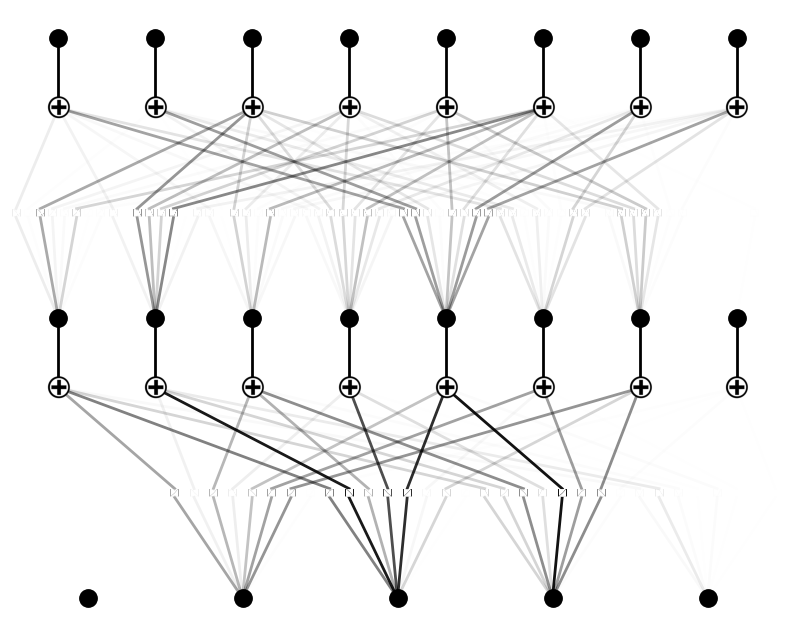

In [18]:
model.plot(scale=1)

In [ ]:
model.auto_symbolic()